### Instrukcje

Tym razem zadanie polega na stworzeniu klasyfikatora obrazków działającego na 50 klasach z różnymi przedmiotami/zwierzętami itp. Do dyspozycji mają Państwo zbiór treningowy podzielony na odpowiednie podfoldery z klasami oraz zbiór testowy - bez podziału. Zbiór treningowy jest przygotowany w taki sposób by można go było łatwo załadować za pomocą klasy torchvision.ImageFolder wywołując np:
trainset = ImageFolder("data/train/", transform=train_transform)
Wówczas wszystkie przykłady zostaną przypisane do odpowiedniej klasy w zależności od tego w jakim podfolderze się znajdowały.
Jako że dane są bardzo duże to umieściłem je na OneDrive:
(train.zip i test_all.zip)

Proszę zwrócić szczególną uwagę na formę zwracanego rozwiązania, bo ostatnio większość z państwa zrobiła to byle jak i miałem bardzo dużo problemów z dodawaniem/usuwaniem niepotrzebnych wierszy itp. Tym razem nie będę poprawiał przesyłanych przez Państwa plików tylko wpisywał 0% accuracy!
W ramach rozwiązania, proszę oddać przez teamsy plik archiwum .zip z kodem (w formie notebooka, lub skryptu/skryptów .py) oraz plikiem .csv z predykcjami na zbiorze testowym. BEZ dodatkowych podfolderów i BEZ danych. W ramach predykcji proszę zapisać tym razem dwie kolumny (bez nagłówków):
Pierwszą kolumnę z nazwami plików testowych (uwaga pliki nazywają się np. 850043533599308.JPEG a nie 850043533599308.jpeg, 850043533599308.jpg czy 850043533599308). Proszę zwrócić na to uwagę bo mój skrypt ewaluacyjny inaczej nie zadziała.
Drugą kolumnę z wartościami oznaczającą predykcję numeru klasy. Klasy ponumerowane są zgodnie z numeracją ze zbioru treningowego (alfabetycznie startując od zera). Po utworzeniu datasetu w oparciu o ImageFolder klasy powinny się tak przypisać autoamtycznie - mogą to państwo sprawdzić wywołując trainset.classes.
Bardzo proszę nazywać wszystkie przesyłane pliki nazwiskami autorów (najlepiej alfabetycznie). Wyszukiwanie kto podpisał się "predictions.csv", a kto projekt_2.ipynb jest uciążliwe. Nazwę głównego archiwum zip, proszę dodatkowo rozpocząć od przedrostka poniedzialek_ lub piatek_, NIE pn,ptk albo coś w tym stylu.
Końcowe wyniki obliczał będę w oparciu o zwykłe accuracy (klasy są zbilansowane).
Uwaga: W zadaniu proszę nie wykorzystywać gotowych architektur o których wspominałem na zajęciach. Proszę też nie kopiować gotowych fragmentów (np. bloki resnetowe itp). Ostatnie laboratorium poświęcone będzie dokładnie temu zagadnieniu.

W MS Teams przydzieliłem zadanie wszystkim uczestnikom, ale bardzo proszę żeby tylko jeden (dowolny) członek zespołu je zwrócił (proszę się dogadać).
W razie pytań zapraszam do korespondencji lub na konsultacje.

# K. Deja w 50 epok - ~50% accuracy na prostym modelu

Jeden zespół w zeszłym semie miał 70%

In [49]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler

import torch.utils.data as data
from sklearn.model_selection import train_test_split

In [6]:
device = torch.device("cuda")

if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)
torch.manual_seed(500)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
device

device(type='cuda')

## Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

## Unzip data

In [ ]:
!unzip /content/drive/MyDrive/colab/train.zip   -d data/
!unzip /content/drive/MyDrive/colab/test_all.zip   -d data/

## Read data

In [7]:
transform_orig = transforms.Compose(
    [transforms.ToTensor()]
)

dataset_no_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_orig)

### Augment data to get more training examples

In [25]:
transform_aug = transforms.Compose(
    [transforms.RandomRotation(25),
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.ToTensor(),
     transforms.RandomErasing(0.5),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

dataset_aug = torchvision.datasets.ImageFolder("data/train/", transform=transform_aug)
dataset = torch.utils.data.ConcatDataset([dataset_no_aug, dataset_aug])

### Get training and validation sets

In [27]:
VALIDATION_SET_RATIO = 0.15
dataset_indices = list(range(len(dataset)))
np.random.shuffle(dataset_indices)
valid_split_index = int(np.floor(VALIDATION_SET_RATIO * len(dataset)))

train_idx, val_idx = dataset_indices[valid_split_index:], dataset_indices[:valid_split_index]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

In [28]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=valid_sampler)

### Dataset classes

In [29]:
classes = dataset_no_aug.classes
(len(classes), classes)

(50,
 ['acoustic',
  'antenna',
  'bacteria',
  'battery',
  'bean',
  'beetle',
  'bicycle',
  'birch',
  'bird',
  'bomb',
  'bread',
  'bridge',
  'camera',
  'carbon',
  'cat',
  'corn',
  'crab',
  'crocodilian',
  'echinoderm',
  'egg',
  'elephant',
  'fish',
  'flower',
  'frog',
  'fungus',
  'gauge',
  'hammer',
  'icecream',
  'kangaroo',
  'memorial',
  'monkey',
  'motor',
  'nest',
  'palm',
  'pizza',
  'pot',
  'printer',
  'saw',
  'snake',
  'spice',
  'spider',
  'spoon',
  'squash',
  'swine',
  'tea',
  'tomato',
  'towel',
  'truck',
  'turtle',
  'worm'])

## Some example images

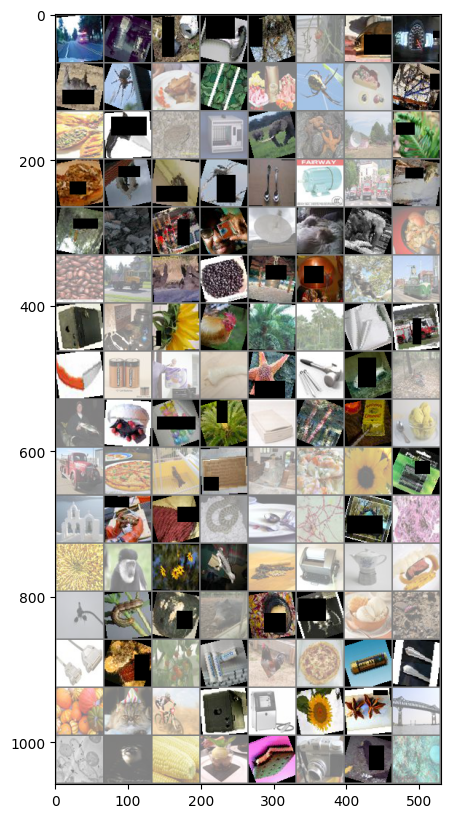

In [46]:
plt.figure(figsize = (5, 10))


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))

## Convolutional neural network

In [89]:
next(iter(train_loader))[0].shape

torch.Size([128, 3, 64, 64])

In [117]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=50, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(50)

        self.conv2 = nn.Conv2d(in_channels=50, out_channels=75, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(75)

        self.conv3 = nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(in_channels=100, out_channels=150, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(150)

        self.conv5 = nn.Conv2d(in_channels=150, out_channels=200, kernel_size=2)
        self.bn5 = nn.BatchNorm2d(200)

        self.conv6 = nn.Conv2d(in_channels=200, out_channels=250, kernel_size=2)
        self.bn6 = nn.BatchNorm2d(250)

        self.fc1 = nn.Linear(5*5*250, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 50)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool(x)

        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.pool(x)

        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

net = Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
N_EPOCHS = 30

for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'[{epoch+1}/{N_EPOCHS}] loss: {running_loss / len(train_loader):.5f}')
    running_loss = 0.0

[1/30] loss: 2.93149
[2/30] loss: 2.35598
[3/30] loss: 2.04432
[4/30] loss: 1.81374
[5/30] loss: 1.62181
[6/30] loss: 1.45020
[7/30] loss: 1.30413
[8/30] loss: 1.18698
[9/30] loss: 1.08257
[10/30] loss: 1.01355
[11/30] loss: 0.95662
[12/30] loss: 0.90505
[13/30] loss: 0.86942
[14/30] loss: 0.84176
[15/30] loss: 0.81833
[16/30] loss: 0.79758
[17/30] loss: 0.77616
[18/30] loss: 0.76014
[19/30] loss: 0.73955
